# Code to place non-spin-flip and spin-flip intensities into bins of constant Qz accounting for change of energy with spin-flip reflection.
M.R. Fitzsimmons (May 14, 2020)

# Import libraries, physical constants, and define functions. 

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import scipy.optimize
from scipy.optimize import curve_fit
import scipy.constants 
import copy

# get physical constants from scipy library
Pi = scipy.constants.pi
hbar = scipy.constants.hbar
m_n = scipy.constants.neutron_mass
mu_n = np.abs(scipy.constants.physical_constants['neutron mag. mom.'][0]) # absolute value of the neutron magnetic moment J/T

# function obtained from 
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# and modified to return the index (idx) and array value (array[idx]) closes to the target.
def find_nearest(array, target):
    array = np.asarray(array)
    idx = (np.abs(array - target)).argmin()
    return array[idx],idx

# function used to find location (b) of a Gaussian shaped peak sitting on a linear background.
def gaussian_and_line(x, a, b, c, d, e):
    return a*np.exp(-0.5*((x-b)/c)**2) + d + e*x


# Opportunity for user to customize some choices.

In [14]:
# Name of the "spin up" data file: (USER INPUT OPPORTUNITY)
file_name_spin_up = 'spin_up.txt' # name for the example, can be changed by user.
# Name of the "spin down" data file: (USER INPUT OPPORTUNITY)
file_name_spin_dw = 'spin_down.txt' # name for the example, can be changed by user.

# Name to store the results: (USER INPUT OPPORTUNITY)
file_output_oo = 'spin_pp.out' # The variable _xx corresponds to the orientation of moment wrt B.
file_output_pp = 'spin_mm.out' # The variable _yy in the string corresponds to the spin of the moment,
file_output_po = 'spin_mp.out' # which is opposite to the moment.
file_output_op = 'spin_pm.out' # These files are compatible with GenX reflectivity analysis program https://genx.sourceforge.io/.

# Number of 1-RMS sigma intervals to integrate over a broad peak (broad for whatever reason).
# A value of 5 is recommended.
nsig = 5 # OPPORTUNITY FOR USER CHANGE.

# User selected resolution, rel_dqz, expressed as a fraction of Qz, i.e., dQz/Qz
# This establishes the size of the Q-bins.
# A value of 4% is recommended.
rel_dqz = 0.04 # Can be adjusted by user OPPORTUNITY FOR USER CHANGE.

# Get the data

We require the neutron time of flight (tof), scattering angle, instrument path lengths, and
 applied magnetic field for "up" and "down" states or channels to be the same.
 The test data set was collected as Run 6231 on the Asterix spectrometer at the
 Los Alamos National Laboratory with a magnetic induction of B = 11 T. 
 For the test data set, the incident beam spin polariation was "up" achieved with
 the spin flipper turned "on". 


## Data File Format:
 First line is two integers containing the number (m) of equal-sized tof channels and 
 the number (n) of equal-sized detector pixels elements corresponding to different scattering angles.
 
 The next m lines are floating point numbers representing the tof of the time bin in seconds.
 The next n lines are floating point numbers representing the scattering angle of the pixel in radians.
 Scattering angle is measured with respect to the center of the incident beam.

 The next 3 lines are floating point numbers for the path lengths from the neutron moderator
 to detector (meter), the sample to detector (meter), and finally the magnetic induction applied to the sample in Tesla.

 The remaining m.n lines are the data listed as the m tof bins (ranging from small to large)
 of jth pixel element (ranging from small scattering angle to large).

 The files are specified by the user's choice in the following block
 for neutron spin polarization "up" and neutron spin polarization "down".

## Alternative:
 If this Qz-binning module is the last part of an analysis workflow, which might include
 background subtraction, spectrum normalization, etc., then the data required for this
 module may be produced by an earlier module provided the data are identified properly.
 In this case the following block of code should not be run.  The requried objects are:

 m (an integer) = number of tof bins of constant width

 n (an integer) = number of detector pixels of constant width

 psd_w_spin_up = 2D array of m by n floating point values for the spin up signal

 var_psd_w_spin_up = 2D array of variances of psd_w_spin_up

 psd_w_spin_dw = 2D array of m by n floating point values for the spin down signal

 var_psd_w_spin_dw = 2D array of variances of psd_w_spin_dw

 tof_w = 1D array of floating point values for the time of flight of each of m bins (seconds)

 two_theta = 1D array of floating point values for the scattering angle of each of n bins (radians)

 l_mod_det = moderator to detector (meters)

 l_sample_det = sample to detector (meters)

 b_induction = B in Tesla

 l_mod_sample = l_mod_det - l_sample_det # moderator to sample (meters)
 


In [15]:
file_up = open(file_name_spin_up,'r')
s = file_up.readline()
m = int(s.split()[0]) # number of tof bins, time in seconds
n = int(s.split()[1]) # number of pixels in direction of wavevector transfer, Qz

tof_w = np.zeros(m, dtype=np.float32) # array of tof in seconds
for i in range(m):
    tof_w[i] = float(file_up.readline())

two_theta = np.zeros(n, dtype=np.float32) # array of scattering angles in radians
for i in range(n):
    two_theta[i] = float(file_up.readline())

l_mod_det = float(file_up.readline()) # moderator to detector (meters)
l_sample_det = float(file_up.readline()) # sample to detector (meters)
b_induction = float(file_up.readline()) # B in tesla
l_mod_sample = l_mod_det - l_sample_det # moderator to sample (meters)

psd_w_spin_up = np.zeros((m,n), dtype=np.float32) # value of each tof-pixel voxol
for j in range(n):
    for i in range(m):
        psd_w_spin_up[i][j] = float(file_up.readline()) # this is spin_up, moment down

file_up.close()

# incident beam polarization down or flipper off
file_dw = open(file_name_spin_dw,'r')
s = file_dw.readline()
m = int(s.split()[0]) # number of tof bins, time in seconds
n = int(s.split()[1]) # number of pixels in direction of wavevector transfer, Qz

tof_w = np.zeros(m, dtype=np.float32) # array of tof in seconds
for i in range(m):
    tof_w[i] = float(file_dw.readline())

two_theta = np.zeros(n, dtype=np.float32) # array of scattering angles in radians
for i in range(n):
    two_theta[i] = float(file_dw.readline())

l_mod_det = float(file_dw.readline()) # moderator to detector (meters)
l_sample_det = float(file_dw.readline()) # sample to detector (meters)
b_induction = float(file_dw.readline()) # B in tesla
l_mod_sample = l_mod_det - l_sample_det # moderator to sample (meters)

psd_w_spin_dw = np.zeros((m,n), dtype=np.float32) # value of each voxol tof-pixel
for j in range(n):
    for i in range(m):
        psd_w_spin_dw[i][j] = float(file_dw.readline())# this is spin_down, moment up

file_dw.close()

# We will binning data (counts) in bins of constant Qz.  We also need to bin the
# variances as well the same way so we can propagate errors. Here we assume the
# are simply number of neutron events detected so the variance is the same as the
# data.  This assumption can be removed if the data files provide variances as well
# as the measurements.

var_psd_w_spin_dw = copy.deepcopy(psd_w_spin_dw)
var_psd_w_spin_up = copy.deepcopy(psd_w_spin_up)

# Find the min of the data array that is not zero. this minimum (likely) corresponds to the
# the signal measured by one neutron event in a single voxol. Because zero events
# could statistically have been one event, we use cmin to place a lower limit on
# the variance of the data.

smin = np.min([np.min(psd_w_spin_dw[np.where(psd_w_spin_dw > 0)]),np.min(psd_w_spin_up[np.where(psd_w_spin_up > 0)])])
d = np.where(psd_w_spin_dw < smin)
var_psd_w_spin_dw[d] = smin
d = np.where(psd_w_spin_up < smin)
var_psd_w_spin_up[d] = smin


# Plot images of the spin down and up channels
Because the gyromagnetic ratio for the neutron is negative, the neutron spin
 and the neutron magnetic moment point in opposite directions.  Conventionally,
 the neutron beam polarization is the ratio of (spin_up - spin_down)/(spin_up + spin_down),
 where spin_up(down) are the number of neutron spins up(down), respectively. The neutron
 data are usually referred to by (polarization) spin state, or channel.  Classically, we think of 
 the magnetic field exerting a torque on a magnetic moment, so if the neutron moment is
 parallel (p) to the applied field (i.e., spin down) then this is a low energy state compared to the case
 for the neutron moment opposite (o) to the field (i.e., spin up).

 With the exception of reading and storing the user data in terms of neutron spin, the notation
 of the code refers to the magnetic moment of the neutron as either p or o with respect
 to the applied field.

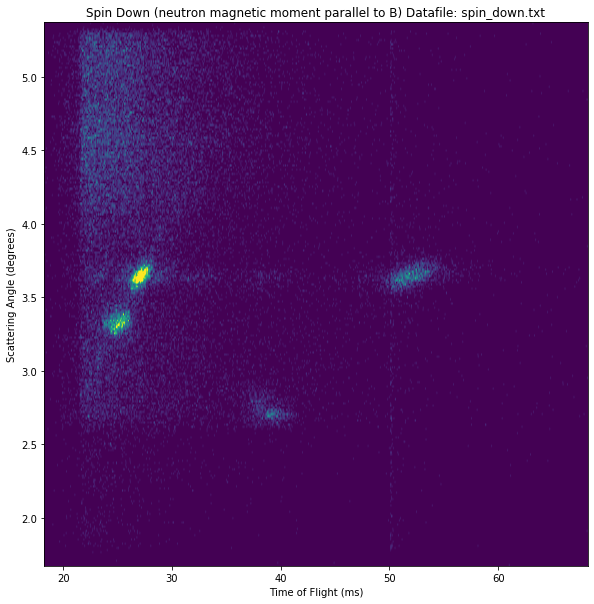

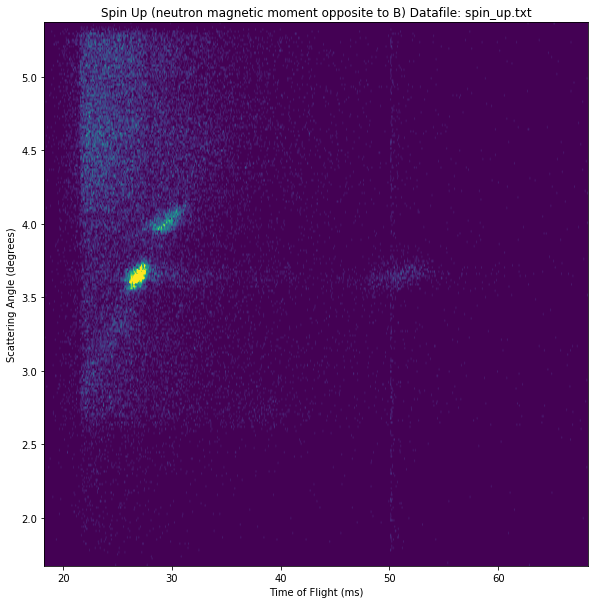

In [16]:
# find max of both images and use it to normalize the images
vmax = max(np.max(psd_w_spin_dw),np.max(psd_w_spin_up))

z = np.flip(np.transpose(psd_w_spin_dw),0)
tofmin = np.min(tof_w)*1000
tofmax = np.max(tof_w)*1000
tthmin = np.min(two_theta)/np.pi*180.
tthmax = np.max(two_theta)/np.pi*180
plt.figure(figsize = (10,10))
plt.xlabel('Time of Flight (ms)')
plt.ylabel('Scattering Angle (degrees)')
plt.title('Spin Down (neutron magnetic moment parallel to B)'+' Datafile: '+file_name_spin_dw)
plt.imshow(z, extent=[tofmin,tofmax,tthmin,tthmax], aspect=(tofmax-tofmin)/(tthmax-tthmin), interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax/3))
plt.show()

z = np.flip(np.transpose(psd_w_spin_up),0)
tofmin = np.min(tof_w)*1000
tofmax = np.max(tof_w)*1000
tthmin = np.min(two_theta)/np.pi*180.
tthmax = np.max(two_theta)/np.pi*180
plt.figure(figsize = (10,10))
plt.xlabel('Time of Flight (ms)')
plt.ylabel('Scattering Angle (degrees)')
plt.title('Spin Up (neutron magnetic moment opposite to B)'+' Datafile: '+file_name_spin_up)
plt.imshow(z, extent=[tofmin,tofmax,tthmin,tthmax], aspect=(tofmax-tofmin)/(tthmax-tthmin), interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax/3))
plt.show()

# Find position and width of centroid for the NSF channel.
Find the two_theta array element and its index closest to the centroid.
 Typically for a specular reflectometry experiment, the detector is moved in two_theta
 (scattering angle) such that the specular reflection strikes the same detector pixel.
 This pixel is the magic pixel--here labeled "c0".

 The importance of c0 is that for a flat detector, neutrons that strike an element
 other than c0 (which the spin-flip neutrons do), travel a longer distance from the
 sample to the detector.  The extra distance affects the time of flight for neutrons
 and is an important correction relative to the change of energy neutrons encounter
 upon SF reflection in a magnetic field (the latter is ~10 ppm).

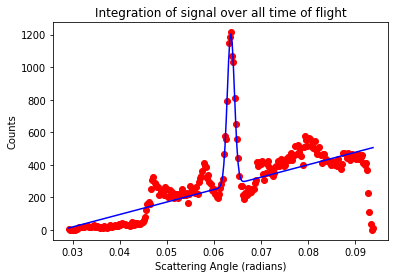

Centroid  =  0.0636 (radians)
RMS width =  0.0008(radians)
Magic pixel = 136


In [17]:
# Integrate detector array over time and sum both spin states.
psd_sum=np.sum(psd_w_spin_dw,axis=0)+np.sum(psd_w_spin_up,axis=0)

# Identify some reasonable guess values (a,b,c) for the Gaussian peak.
# We are after the location of the peak, b, and its root mean square width, c.
a=np.amax(psd_sum)
b=two_theta[np.where(psd_sum==a)]
b=b[0]
c=(np.max(two_theta)-np.min(two_theta))/m * 5

# d (intercept) and e (slope) are estimates for the linear background function.
d = 0.
e = 0.

popt, pcov = curve_fit(gaussian_and_line, two_theta, psd_sum, p0=[a,b,c,d,e])

centroid = popt[1]
rms_width = popt[2]

# Find c0
g,c0 = find_nearest(two_theta,centroid)

plt.title('Integration of signal over all time of flight')
plt.xlabel('Scattering Angle (radians)')
plt.ylabel('Counts')
plt.plot(two_theta,psd_sum,'ro')
plt.plot(two_theta,gaussian_and_line(two_theta, *popt),'b-')
plt.show()

print('Centroid  = %7.4f (radians)'%centroid)
print('RMS width = %7.4f(radians)'%rms_width)
print('Magic pixel = %s'%c0)

# A portion of the detector maybe shadowed by slits. We do not want to allow
# for contributions to the Qz-binning that lie in a shadow.
# Provide an opportunity to define lower and upper limits of a gross region
# of interest for the detector.  These limits should be set as large as possible 
# to include the non-shadowed region.  Use of a gross ROI does not affect the NSF
# binning because the specular beam is located in close proximity to c0.  But,
# as we will see later, the Qz-binning for the SF case involving change of neutron
# velocity with SF reflection, follows contours that potentially terminate in a shadow.
# We don't want to include shadowed events (probably zeros) in our SF binning.  Zeros
# should contribute if the pixel is not shadowed and genuinely measured a zero. While 
# the event is a zero, the possibility to measure it affects the Jacobian of the 
# transformation from real to reciprocal space.

gross_roi_lo_limit = 0
gross_roi_hi_limit = n-1

# Offer an opportunity to redefine the detector's gross region of interest. 
The user should inspect the previous plot and decide on the overall region of interest
 for the entire detector.  This involves identifying in scattering angle the lower
 and upper limits of the detector which enclose the region that is not shadowed by slits.

 By default the entire detector is chosen for binning of the SF intensities.  If the user
 is satisfied with the default, then following block should not be run, or if run, then the
 default limits should be uncommented.
    
 In the example the slits shadow regions for two_theta < ~0.046 radians and > ~0.092.

 Note that the choice of the ROI over which to integrate the NSF intensities is determined
 differently and explained further shortly.  

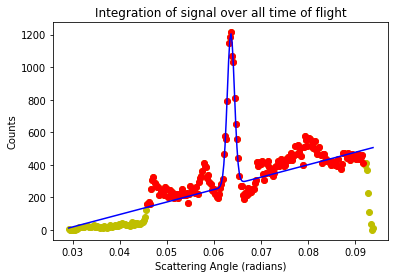

Data appearing as "yellow" will be excluded from further analysis.
Absolute low limit of detector = 66
Absolute high limit of detector = 248


In [18]:
gross_lo_angle_limit = 0.046 # user chosen here OPPORTUNITY FOR USER CHANGE.
gross_hi_angle_limit = 0.092 # user chosen here OPPORTUNITY FOR USER CHANGE.
g,gross_roi_lo_limit = find_nearest(two_theta,gross_lo_angle_limit)
g,gross_roi_hi_limit = find_nearest(two_theta,gross_hi_angle_limit)

# gross_roi_lo_limit = 0 # default
# gross_roi_hi_limit = n-1 # default

plt.title('Integration of signal over all time of flight')
plt.xlabel('Scattering Angle (radians)')
plt.ylabel('Counts')
plt.plot(two_theta,psd_sum,'yo')
plt.plot(two_theta[gross_roi_lo_limit:gross_roi_hi_limit],psd_sum[gross_roi_lo_limit:gross_roi_hi_limit],'ro')
plt.plot(two_theta,gaussian_and_line(two_theta, *popt),'b-')
plt.show()

print('Data appearing as "yellow" will be excluded from further analysis.')
print('Absolute low limit of detector = %s'%gross_roi_lo_limit)
print('Absolute high limit of detector = %s'%gross_roi_hi_limit)

# Establish the region of interest in scattering angle for NSF channel. 
Establish the ROI over which to integrate the NSF intensities.
 The ROI has a width, because the specular beam is broad due
 to divergence of the incident beam and sample bending.
 We account for these affects on the reflectivity by binning along 
 contours of constant Qz.  The binning takes into account that for 
 the same Qz different trajectories of the specularly reflected neutron
 will have a unique wavelength. Here, the width of the ROI is nsig=5 
 times the rms_width of the reflection, in order to ensure all the 
 specular reflectivity is considered.

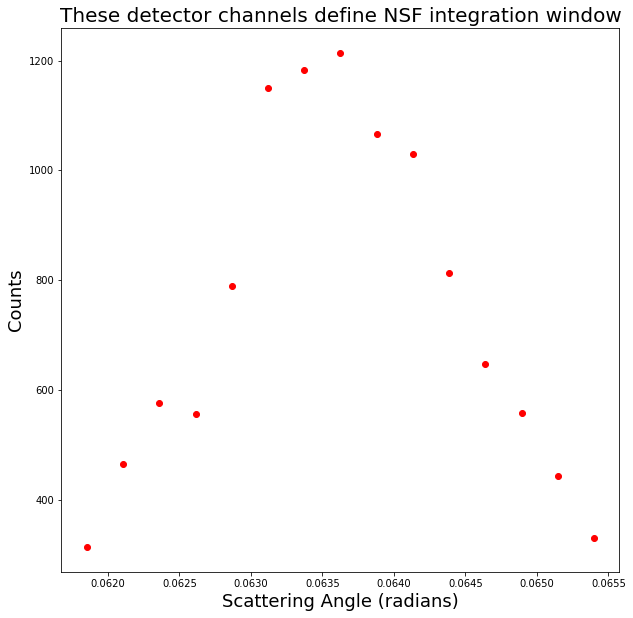

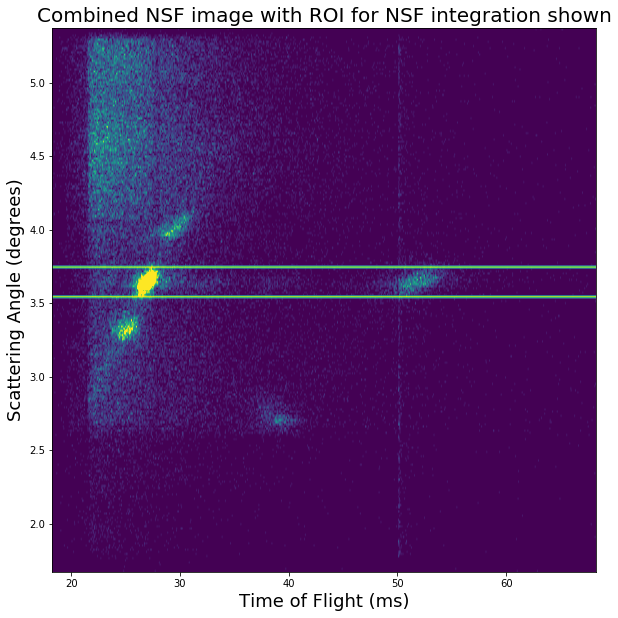

Lower limit of ROI = 129
Upper limit of ROI = 143


In [19]:
b = two_theta <= centroid + nsig/2.*rms_width
c = centroid - nsig/2.*rms_width <= two_theta
d = b & c

npix = len(two_theta[d])

roi_lo=np.where(two_theta==min(two_theta[d]))[0] # index corresponding to the bottom of the ROI
roi_hi=np.where(two_theta==max(two_theta[d]))[0] # index corresponding to the top of the ROI

plt.figure(figsize = (10,10))
plt.title('These detector channels define NSF integration window', fontsize=20)
plt.xlabel('Scattering Angle (radians)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.plot(two_theta[d],psd_sum[d],'ro')
plt.show()

# l_mod_det is flight path from moderator to the centroid position in the detector.
# For NSF there is no need to apply a flat detector correction, because
# the NSF specular reflection is seen only in proximity to the centroid.

v0 = l_mod_det / tof_w # velocity of the NSF neutron beam (m/s)
k0 = m_n*v0/hbar # magnitude of the wavevector of the NSF neutron beam (1/m)
lambda_nsf = 2*Pi/k0 * 1e10 # wavelength of the NSF beam in Angstroms, thus factor of 1e10

# qz_nsf is the Qz values for every voxol (tof-angle pixel element)
qz_nsf = np.zeros((m,n), dtype=np.float32)
for i in range(npix):
    qz_nsf[:,roi_lo[0]+i]=2*np.pi/lambda_nsf*two_theta[roi_lo[0]+i]

z = psd_w_spin_up + psd_w_spin_dw
z[:,roi_lo[0]] = vmax/3
z[:,roi_hi[0]] = vmax/3
z = np.flip(np.transpose(z),0)
tofmin = np.min(tof_w)*1000
tofmax = np.max(tof_w)*1000
tthmin = np.min(two_theta)/np.pi*180.
tthmax = np.max(two_theta)/np.pi*180
plt.figure(figsize = (10,10))
plt.xlabel('Time of Flight (ms)', fontsize=18)
plt.ylabel('Scattering Angle (degrees)', fontsize=18)
plt.title('Combined NSF image with ROI for NSF integration shown', fontsize=20)
plt.imshow(z, extent=[tofmin,tofmax,tthmin,tthmax], aspect=(tofmax-tofmin)/(tthmax-tthmin), interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax/3))
plt.show()

# Ensure the ROI of the NSF is inside the gross limits of the detector
if roi_lo[0] < gross_roi_lo_limit: 
    roi_lo[0] = gross_roi_lo_limit
if roi_hi[0] > gross_roi_hi_limit:
    roi_hi[0] = gross_roi_hi_limit

print('Lower limit of ROI = %s'%roi_lo[0])
print('Upper limit of ROI = %s'%roi_hi[0])

# Make Qz-bins for the NSF and SF.
Establish limits for the Qz binning scheme. This code use "rel_dqz" defined in the user block.

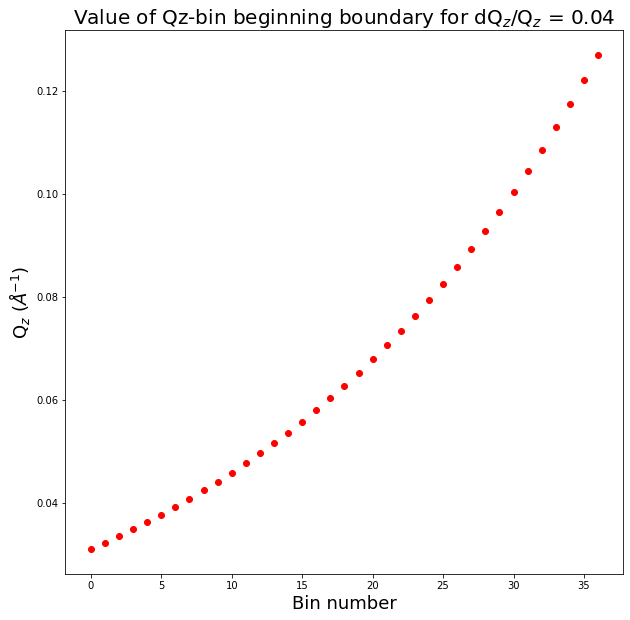

In [20]:
qz_max=np.max(qz_nsf)
d = np.where(qz_nsf > 0)
qz_min=np.min(qz_nsf[d])
# Bin so as to keep resolution in Qz bins constant.
p = int(np.log(qz_max/qz_min)/np.log(1+rel_dqz)+1)+1
qbins = np.zeros(p, dtype=np.float32)

for i in range(p):
    qbins[i]=(1+rel_dqz)**i*qz_min # qz values for start of each bin
    
plt.figure(figsize = (10,10))
plt.title('Value of Qz-bin beginning boundary for dQ$_z$/Q$_z$ = %s'%rel_dqz, fontsize=20)
plt.xlabel('Bin number', fontsize=18)
plt.ylabel('Q$_z$ ($\AA$$^{-1}$)', fontsize=18)
plt.plot(qbins,'ro')
plt.show()


# Qz-bin the NSF intensities 
The Qz-bins are defined by boundaries in Qz; there are p boundaries.
 We integrate counts between boundaries so there are p-1 bins.
 In other words, there are p Qz-bin boundaries and p-1 Qz-bins.
 Later, we define Qz of a bin to be the average of the Qz's at its boundaries.
    
 Note, to transform from real-space to reciprocal-space we need to know the
 determinant of the Jacobian of the transformation. Because we use constant step size of
 dtof and constant step size of dbeta--
 an approximation for a flat detector, which is acceptable for a small enough
 detector far enough from the sample--
 the "area" subtended by each voxol is constant with tof and beta.
 This means the determinant(Jacobian) is just the number of Qz 
 elements (with different tof and beta) 
 that contribute to the Qz-bin. 

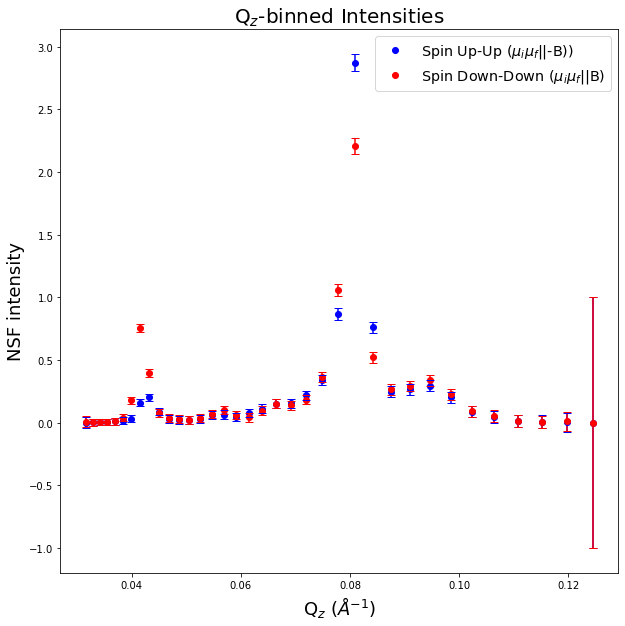

In [21]:
qz = np.zeros(p-1, dtype=np.float32)
for i in range(p-1):
    qz[i] = (qbins[i]+qbins[i+1])/2. # qz value for the mean of the bin

# array "s" denotes scattering cross-section, pp, oo, po and op refer
# to neutron moment alignment relative to applied field.
# s_pp and s_oo will contain the NSF qz-binned intensities

s_pp = np.zeros(p-1, dtype=np.float32)
s_oo = np.zeros(p-1, dtype=np.float32)

# and the variances
v_pp = np.zeros(p-1, dtype=np.float32)
v_oo = np.zeros(p-1, dtype=np.float32)

for i in range(p-1):
    b = qz_nsf <= qbins[i+1]
    c = qbins[i] <= qz_nsf
    d = b & c
    s_oo[i] = np.sum(psd_w_spin_up[d])/len(qz_nsf[d]) # Remember spin and moment are opposite and moment || B.
    s_pp[i] = np.sum(psd_w_spin_dw[d])/len(qz_nsf[d])
    v_oo[i] = np.sum(var_psd_w_spin_up[d])/np.square(len(qz_nsf[d])) # Whatever is done to data is done to the square to variance
    v_pp[i] = np.sum(var_psd_w_spin_dw[d])/np.square(len(qz_nsf[d]))

fig, ax = plt.subplots(figsize = (10,10))
plt.title('Q$_z$-binned Intensities',fontsize=20)
plt.xlabel('Q$_z$ ($\AA$$^{-1}$)',fontsize=18)
plt.ylabel('NSF intensity',fontsize=18)
ax.plot(qz,s_oo,'bo',label='Spin Up-Up ($\mu_i\mu_f$||-B))')
ax.plot(qz,s_pp,'ro',label='Spin Down-Down ($\mu_i\mu_f$||B)')
ax.errorbar(qz,s_oo,yerr=np.sqrt(v_oo),capsize=4,ls='None',ecolor='b')
ax.errorbar(qz,s_pp,yerr=np.sqrt(v_pp),capsize=4,ls='None',ecolor='r')
legend = ax.legend(loc='upper right', fontsize='x-large')
plt.show()


# For SF case compute the incident and final wavelengths.
The time-of-flight (tof) is a combination of lambda_i from moderator to sample (the neutron wavelength
 before reflection, i.e., the wavelength of the incident neutron beam)
 and lambda_f from the sample to detector (the wavelength of the neutron beam after reflection).  
 For case of SF reflection in a magnetic field, 
 lambda_f is not the same as lambda_i.  The consequence
 is that the tof we measure combines neutrons of two different
 velocities (wavelengths) weighted by the different path lengths.  The math
 requires finding a root of a cubic equation. I used Brent's method.
 "po" means the moment parallel to B flips to be opposite to B after reflection.
 "op" means the moment opposite to B flips to be parallel to B after reflection.
 Note, for the case of a continuous wave source, for which the wavelength of the incident neutron
 beam is constant, the problem is simpler (and the cubic equation is not needed).

 References that discuss how SF reflection changes the energy (thus velocity and wavelength)
 and the consequences for how the SF intensities are displaced in scattering angle 
 corresponding to "op" and "po" are:

 G.P. Felcher et al., Nature 377, 409 (1995)

 G.P. Felcher et al., Physica B 221, 494 (1996).

 M.R. Fitzsimmons et al., Phys. Rev. B, 73, 134413 (2006).

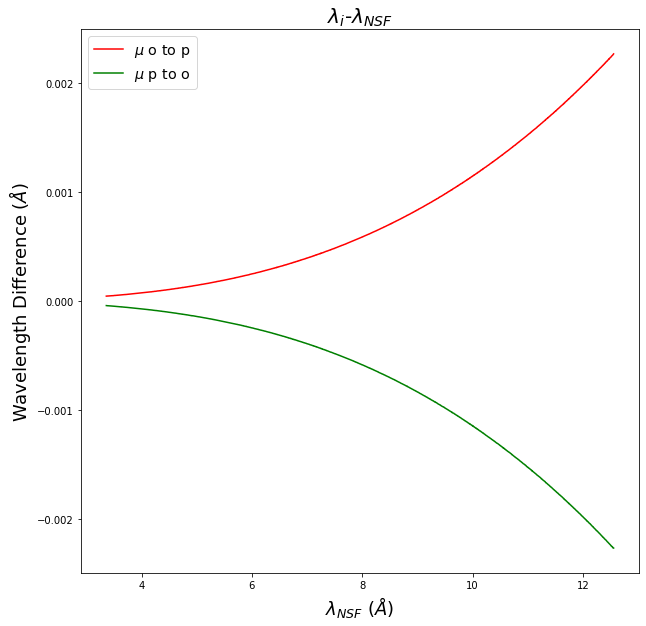

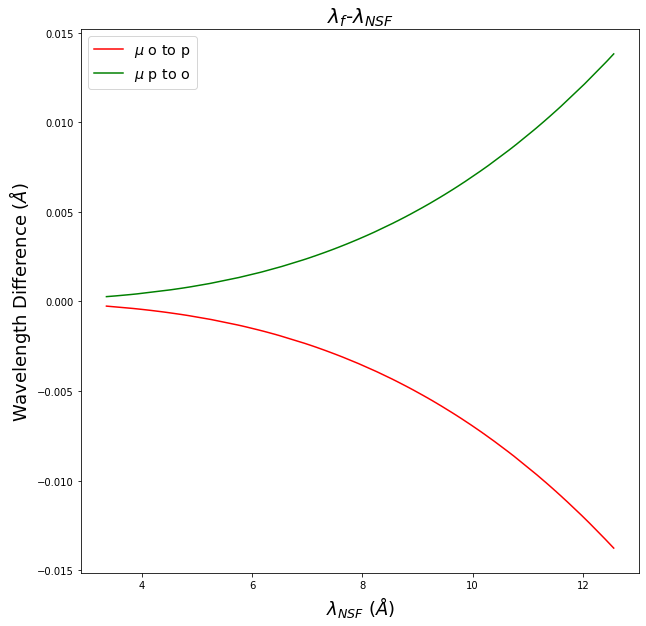

In [22]:
# The real solution to this equation (or the real root) is 1/k=x or the incident
# wavevector for the po transition.
def lroot_po(x,d,s,m,hbar,omega,mu,B,t):
    return d*m/hbar*x*(1+(s/d)/np.cos(omega)/np.sqrt(1-4*m/hbar**2*mu*B*x**2))-t

# likewise for the op transition.
def lroot_op(x,d,s,m,hbar,omega,mu,B,t):
    return d*m/hbar*x*(1+(s/d)/np.cos(omega)/np.sqrt(1+4*m/hbar**2*mu*B*x**2))-t

kipo = np.zeros((m,n), dtype=np.float32) # incident beam wavevector before p to o flip
kiop = np.zeros((m,n), dtype=np.float32) # incident beam wavevector before o to p flip

# The roots will be close to the incident beam neutron wavelngth for  B = 0, or NSF,
# use the NSF value, k0, as the initial guess.
for i in range(m):
    for j in range(n):
        u = scipy.optimize.brentq(lroot_po,0.95/k0[i],1.05/k0[i],args=(l_mod_sample,l_sample_det,m_n,hbar,two_theta[j]-centroid,mu_n,b_induction,tof_w[i]))
        kipo[i,j] = 1/u
        v = scipy.optimize.brentq(lroot_op,0.95/k0[i],1.05/k0[i],args=(l_mod_sample,l_sample_det,m_n,hbar,two_theta[j]-centroid,mu_n,b_induction,tof_w[i]))
        kiop[i,j] = 1/v
# Note, units of k are 1/m.
        
lambda_i_po = 2*Pi/kipo * 1e10 # convert to Angstroms
lambda_i_op = 2*Pi/kiop * 1e10 # convert to Angstroms

fig, ax = plt.subplots(figsize = (10,10))
plt.title('$\lambda_i$-$\lambda_{NSF}$', fontsize=20)
plt.xlabel('$\lambda_{NSF}$ ($\AA$)', fontsize=18)
plt.ylabel('Wavelength Difference ($\AA$)', fontsize=18)
ax.plot(lambda_nsf,lambda_i_op[:,c0]-lambda_nsf,'r-',label='$\mu$ o to p')
ax.plot(lambda_nsf,lambda_i_po[:,c0]-lambda_nsf,'g-',label='$\mu$ p to o')
legend = ax.legend(loc='upper left', fontsize='x-large')
plt.show()

kfpo = np.sqrt(kipo**2-4*m_n/hbar**2*mu_n*b_induction)
kfop = np.sqrt(kiop**2+4*m_n/hbar**2*mu_n*b_induction)
         
lambda_f_op = 2*Pi/kfop * 1e10 # convert to Angstroms
lambda_f_po = 2*Pi/kfpo * 1e10 # convert to Angstroms

fig, ax = plt.subplots(figsize = (10,10))
plt.title('$\lambda_f$-$\lambda_{NSF}$', fontsize=20)
plt.xlabel('$\lambda_{NSF}$ ($\AA$)', fontsize=18)
plt.ylabel('Wavelength Difference ($\AA$)', fontsize=18)
plt.plot(lambda_nsf,lambda_f_op[:,c0]-lambda_nsf,'r-',label='$\mu$ o to p')
plt.plot(lambda_nsf,lambda_f_po[:,c0]-lambda_nsf,'g-',label='$\mu$ p to o')
legend = ax.legend(loc='upper left', fontsize='x-large')
plt.show()

# the reversal of the i and f states for lambda is reasonable because, take
# a p to o transition. after flipping to o the potential well is larger for the
# f-neutron so it's kinetic energy must go down, meaning vf and kf go down so lambdaf
# goes up. this is seen in the green curve second figure.  for constant tof, if 
# the neutron is slower in the f state it must have be faster in the i state to
# keep tof constant, so ki and vi must get larger so lambdai gets smaller. this
# is seen in the green curve of the first figure.


# Identify voxols for SF Qz-binning, show the mask and the contours.
Contours of constant Qz tend to go from lower left corner to upper right
 of an image plotted as a function of scattering angle (bottom to top) and
 wavelength (left to right).
 All neutrons along such a contour have the same value of Qz.  This contour
 is called a contour of constant Qz.
 What determines where the SF reflection will be found displaced along a
 constant Qz contour is the requirement for equality of the in-plane
 components of the wavevectors before and after reflection (the surface
 cannot change the momentum parallel to it).  This requirement forms
 contours that go from the left side towards the upper or lower edges
 depending upon whether we have op (spin up-down) or po (spin down-up) SF reflection, respectively.  
 The displacement of the SF intensities away from the NSF instensities is due
 to the change of energy of a neutron upon adiabatic SF reflection. The larger the magnetic
 field the larger the displacement.
    
 We first calculate the Qz's for all elements in the tof-angle range
 independently for po and op moment flips (SF).
 Next, we identify contours of parallel-component-equality corresponding to
 upper and lower limits of incident beam angle, alpha, that are consistent
 with the nsig*rms_width used for Qz-binning of the NSF intensities.
 These form two contours that we plot.  For Qz's in the map lying outside of
 these boundaries we reset their values to zero.  The zero value means the voxols
 outside the limits of the contours fulfilling the equality of parallel components
 of momentum across the interface will not be used in Qz-binning of the SF intensities, because
 they do not fulfill the equality requirement.
 Then, we calculate the Qz-s within these contours.

 Finally, we show images of the spin-down and up intensities, and overlay the contours
 bounding the region that we will use for the constant Qz binning of the SF intensities.
 If the magnetic induction B is correct, then the limiting contours should bound the
 SF intensities.  In the test example the SF reflectivity is quite strong and the spots
 correspond to superlattice reflections.

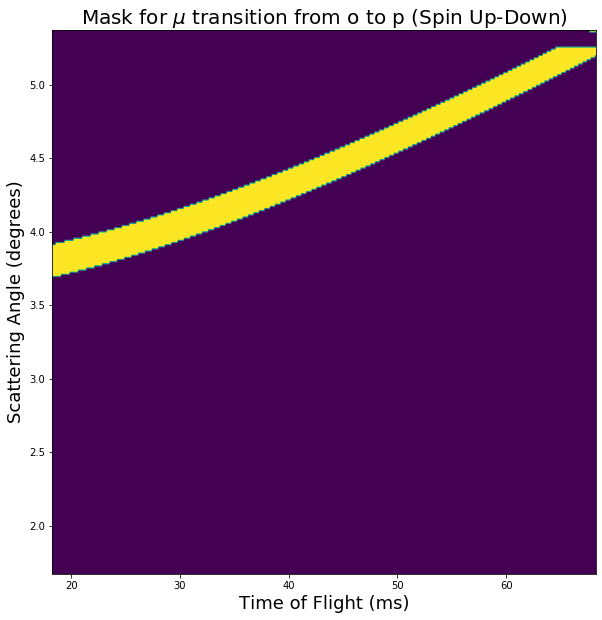

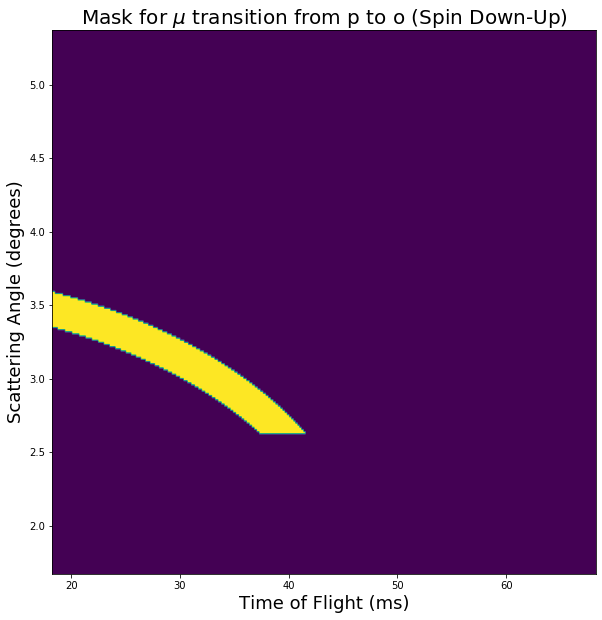

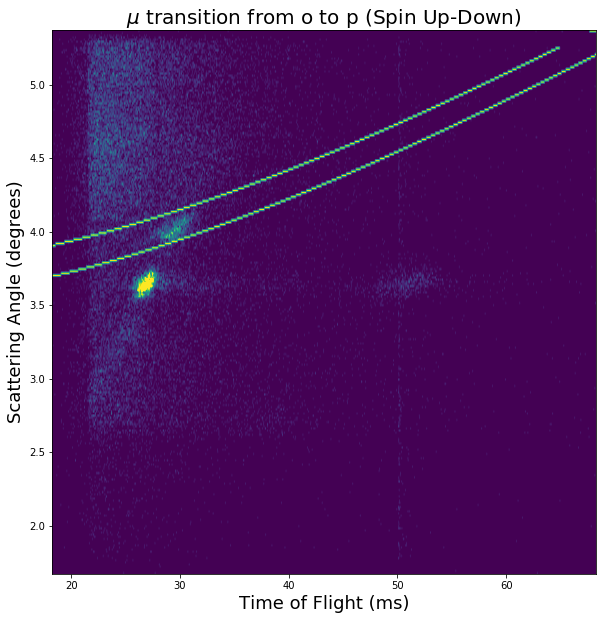

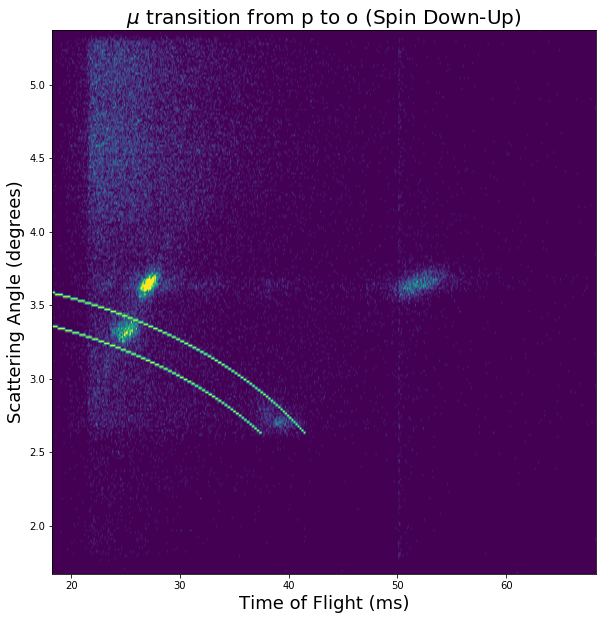

In [23]:
op_truth = np.full((m,n), False) # contain contour of contant k-parallel for op
po_truth = np.full((m,n), False) # contain contour of contant k-parallel for po

# establishes the qz map

alpha = centroid / 2 # incident angle
beta = two_theta - alpha # departure angle measured relative to surface

# calculate Qz for all voxols.
qz_op = np.zeros((m,n), dtype=np.float32) # lambdaf < lambdai sped up
qz_po = np.zeros((m,n), dtype=np.float32) # lambdaf > lambdai slowed down

for i in range(n):   
    qz_op[:,i] = (kfop[:,i]*np.sin(beta[i]) + kiop[:,i]*np.sin(np.abs(alpha)))*1e-10 #inverse Angstroms
    qz_po[:,i] = (kfpo[:,i]*np.sin(beta[i]) + kipo[:,i]*np.sin(np.abs(alpha)))*1e-10 #inverse Angstroms

# now start two cycles interating upper and lower alpha limits based on specular width
# In case of NSF scattering, the depressed trajectory would hit at the lower
# ROI limit of the NSF specular.  This channel, roi_lo selects a specific value
# for the second dimension of the ki map. In other words the incident beam trajectory
# for case of alpha-dalpha is somewhat different (longer) than the case of a trajectory
# along alpha.  This means the tof is somewhat different and these tof's were calculated
# earlier--they vary with alpha, so that for a constant tof, a neutron travelling along 
# alpha-dalpha is somewhat faster than one travelling along alpha.

# lower limit

alpha_p = centroid/2 - nsig/2*rms_width/2 # incident angle extra factor of 1/2 needed, because two_theta is twice alpha

kiop_inplane = kiop[:,roi_lo]*np.cos(alpha_p) # value of in-plane component of incident wavevector for op
kipo_inplane = kipo[:,roi_lo]*np.cos(alpha_p) # for po

# cause specular width is rms_width
beta = two_theta - alpha_p # departure angle measured relative to surface

# now find the detector pixel for which kf in plane is closest to ki in plane
for i in range(m):
    kfop_inplane = kfop[i,:]*np.cos(beta)
    g,idx = find_nearest(kfop_inplane,kiop_inplane[i][0])
    error = np.abs((kiop_inplane[i][0]-g)/kiop_inplane[i][0])
    op_truth[i,idx] = True # for elements op_truth = True, these fulfill the in-plane equality requirement.
    kfpo_inplane = kfpo[i,:]*np.cos(beta)
    g,idx = find_nearest(kfpo_inplane,kipo_inplane[i][0])
    error = np.abs((kipo_inplane[i][0]-g)/kipo_inplane[i][0])
    if error < 1e-4: # protects against running to boundary of detector
        po_truth[i,idx] = True

# Upper limit

alpha_p = centroid / 2 + nsig/2*rms_width/2 # incident angle extra factor of /2 needed

kiop_inplane = kiop[:,roi_hi]*np.cos(alpha_p)
kipo_inplane = kipo[:,roi_hi]*np.cos(alpha_p)

# cause specular width is rms_width
beta = two_theta - alpha_p # departure angle measured relative to surface

# now find the detector pixel for which kf in plane is closest to ki in plane
for i in range(m):
    kfop_inplane = kfop[i,:]*np.cos(beta)
    g,idx = find_nearest(kfop_inplane,kiop_inplane[i][0])
    error = np.abs((kiop_inplane[i][0]-g)/kiop_inplane[i][0])
    op_truth[i,idx] = True
    d = np.where(op_truth[i,:] == True) # op state code can generate single element at boundary
    if len(d[0]) == 1:
        op_truth[i,:] = False
    kfpo_inplane = kfpo[i,:]*np.cos(beta)
    g,idx = find_nearest(kfpo_inplane,kipo_inplane[i][0])
    error = np.abs((kipo_inplane[i][0]-g)/kipo_inplane[i][0])
    if error < 1e-4: # protects against running to boundary of detector
        po_truth[i,idx] = True
    d = np.where(po_truth[i,:] == True) # po state code can generate single element at boundary
    if len(d[0]) == 1:
        po_truth[i,:] = False
        
op_truth_c = copy.deepcopy(op_truth) # these store the two limits as curves
po_truth_c = copy.deepcopy(po_truth) # we do this copy to overlay on an image later
# Ensure the SF region to integrate is contained within the gross ROI of the detector.
op_truth_c[:,0:gross_roi_lo_limit] = False
op_truth_c[:,gross_roi_hi_limit:n-1] = False
po_truth_c[:,0:gross_roi_lo_limit] = False
po_truth_c[:,gross_roi_hi_limit:n-1] = False

# At this point we have a pair of parallel continuity contours limiting Qz values.
# We want all Qz elements between the two contours (these fulfill the 
# in-plane equality requirement), to be Qz-binned, so set the truth table to True for these.

for i in range(m):
    d = np.where(op_truth[i,:] == True)
    if len(d[0]) > 1:
        op_truth[i,d[0][0]:d[0][1]] = True
    d = np.where(po_truth[i,:] == True)
    if len(d[0]) > 1:
        po_truth[i,d[0][0]:d[0][1]] = True

# Ensure the SF region to integrate is contained within the gross ROI of the detector,
# so set value outside this ROI to False.
op_truth[:,0:gross_roi_lo_limit] = False
op_truth[:,gross_roi_hi_limit:n-1] = False
po_truth[:,0:gross_roi_lo_limit] = False
po_truth[:,gross_roi_hi_limit:n-1] = False
        
# Now apply boolean mask only after truth mask finished
# this sets all the Qz values that do not fulfill the in-plane equality requirement to 0.

qz_op[np.where(op_truth == False)] = 0.
qz_po[np.where(po_truth == False)] = 0.

# show the mask, where yellow is True or 1 and purple is False or 0

mask = np.zeros((m,n))
mask[np.where(op_truth == True)] = 1
z = np.flip(np.transpose(mask),0)
plt.figure(figsize = (10,10))
plt.title('Mask for $\mu$ transition from o to p (Spin Up-Down)', fontsize=20)
plt.xlabel('Time of Flight (ms)', fontsize=18)
plt.ylabel('Scattering Angle (degrees)', fontsize=18)
plt.imshow(z, extent=[tofmin,tofmax,tthmin,tthmax], aspect=(tofmax-tofmin)/(tthmax-tthmin), interpolation='bilinear', cmap=cm.viridis, vmax=1, vmin=0)
plt.show()

mask = np.zeros((m,n))
mask[np.where(po_truth == True)] = 1
z = np.flip(np.transpose(mask),0)
plt.figure(figsize = (10,10))
plt.title('Mask for $\mu$ transition from p to o (Spin Down-Up)', fontsize=20)
plt.xlabel('Time of Flight (ms)', fontsize=18)
plt.ylabel('Scattering Angle (degrees)', fontsize=18)
plt.imshow(z, extent=[tofmin,tofmax,tthmin,tthmax], aspect=(tofmax-tofmin)/(tthmax-tthmin), interpolation='bilinear', cmap=cm.viridis, vmax=1, vmin=0)
plt.show()

# Show the limiting contours on the image of the data.

x = copy.deepcopy(psd_w_spin_up)
x[np.where(op_truth_c == True)] = vmax/3
x = np.flip(np.transpose(x),0)
tofmin = np.min(tof_w)*1000
tofmax = np.max(tof_w)*1000
tthmin = np.min(two_theta)/np.pi*180.
tthmax = np.max(two_theta)/np.pi*180
plt.figure(figsize = (10,10))
plt.title('$\mu$ transition from o to p (Spin Up-Down)', fontsize=20)
plt.xlabel('Time of Flight (ms)', fontsize = 18)
plt.ylabel('Scattering Angle (degrees)', fontsize=18)
plt.imshow(x, extent=[tofmin,tofmax,tthmin,tthmax], aspect=(tofmax-tofmin)/(tthmax-tthmin), interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax/3))
plt.show()

z = copy.deepcopy(psd_w_spin_dw) # this to ensure we don't change the original data.
z[np.where(po_truth_c == True)] = vmax/3
z = np.flip(np.transpose(z),0)
tofmin = np.min(tof_w)*1000
tofmax = np.max(tof_w)*1000
tthmin = np.min(two_theta)/np.pi*180.
tthmax = np.max(two_theta)/np.pi*180
plt.figure(figsize = (10,10))
plt.title('$\mu$ transition from p to o (Spin Down-Up)', fontsize = 20)
plt.xlabel('Time of Flight (ms)', fontsize = 18)
plt.ylabel('Scattering Angle (degrees)', fontsize=18)
plt.imshow(z, extent=[tofmin,tofmax,tthmin,tthmax], aspect=(tofmax-tofmin)/(tthmax-tthmin), interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax/3))
plt.show()

# Perform Qz-binning of the SF intensities.
For SF Qz-binning, we integrate over values of Qz that are constant, and these fall inside the
 limiting contours coming from the equality of in-plane components across the interface. The constant
 Qz contours tend to run from lower left to upper right of the scatteing angle vs. tof
 image inside the bounded region. 
    
 The final answers are Qz, s, error on s for each cross-section in separate files.
 The error is the standard deviation not the variance! The names of the output files
 were chosen by the user at the beginning of the module. The files can be directly imported
 into specular reflectivity modeling software like Genx. See: https://genx.sourceforge.io/

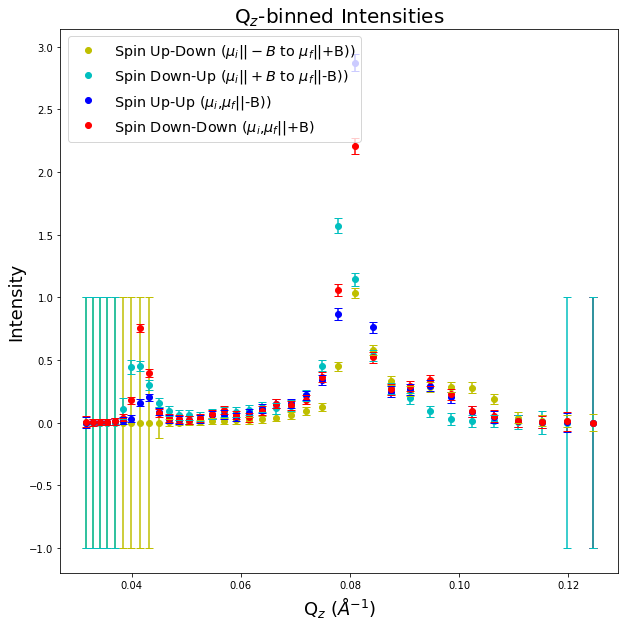

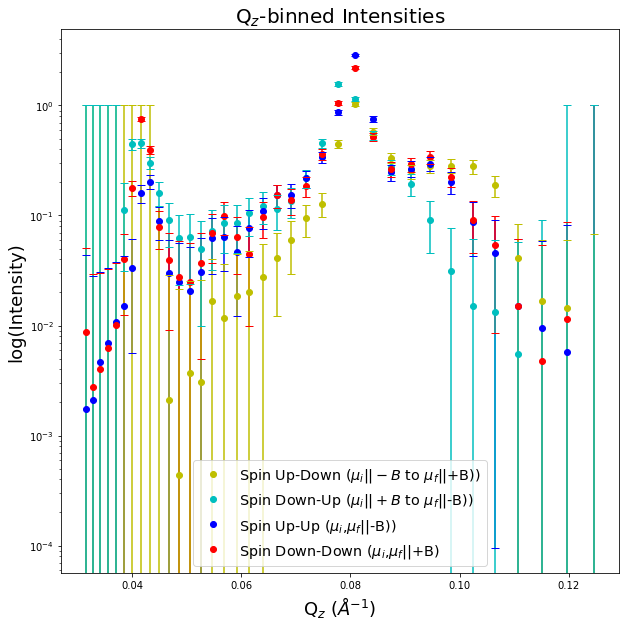

In [24]:
s_op = np.zeros(p-1, dtype=np.float32)
s_po = np.zeros(p-1, dtype=np.float32)

# and the variances
v_op = np.zeros(p-1, dtype=np.float32)
v_po = np.zeros(p-1, dtype=np.float32)

check_mask = np.zeros((m,n))

for i in range(p-1):
    b = qz_op <= qbins[i+1]
    c = qbins[i] <= qz_op
    d = b & c
    check_mask[d] = 1 # identify elements with Qz's inside the i-th Qz-bin.
    if len(qz_op[d]) != 0:
        s_op[i] = np.sum(psd_w_spin_up[d])/len(qz_op[d]) # note consistent with moment defintion not spin
        v_op[i] = np.sum(var_psd_w_spin_up[d])/np.square(len(qz_op[d])) # note consistent with moment defintion not spin

for i in range(p-1):
    b = qz_po <= qbins[i+1]
    c = qbins[i] <= qz_po
    d = b & c
    check_mask[d] = 1 # identify elements with Qz's inside the i-th Qz-bin.
    if len(qz_po[d]) != 0:
        s_po[i] = np.sum(psd_w_spin_dw[d])/len(qz_po[d]) # note consistent with moment defintion not spin
        v_po[i] = np.sum(var_psd_w_spin_dw[d])/np.square(len(qz_po[d])) # note consistent with moment defintion not spin

# There are entries that are not allowed to be populated by the mask. These correspond
# to regions outside the gross ROI limits of the detector.  Assign the smallest non-zero
# variance to these values

d = np.where(v_op == 0)
v_op[d] = smin
d = np.where(v_po == 0)
v_po[d] = smin
       
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Q$_z$-binned Intensities',fontsize=20)
plt.xlabel('Q$_z$ ($\AA$$^{-1}$)',fontsize=18)
plt.ylabel('Intensity',fontsize=18)
ax.plot(qz,s_op,'yo',label='Spin Up-Down ($\mu_i||-B$ to $\mu_f$||+B))')
ax.plot(qz,s_po,'co',label='Spin Down-Up ($\mu_i||+B$ to $\mu_f$||-B))')
ax.plot(qz,s_oo,'bo',label='Spin Up-Up ($\mu_i$,$\mu_f$||-B))')
ax.plot(qz,s_pp,'ro',label='Spin Down-Down ($\mu_i$,$\mu_f$||+B)')
legend = ax.legend(loc='upper left', fontsize='x-large')
ax.errorbar(qz,s_oo,yerr=np.sqrt(v_oo),capsize=4,ls='None',ecolor='b')
ax.errorbar(qz,s_pp,yerr=np.sqrt(v_pp),capsize=4,ls='None',ecolor='r')
ax.errorbar(qz,s_op,yerr=np.sqrt(v_op),capsize=4,ls='None',ecolor='y')
ax.errorbar(qz,s_po,yerr=np.sqrt(v_po),capsize=4,ls='None',ecolor='c')
plt.show()

fig, ax = plt.subplots(figsize = (10,10))
plt.title('Q$_z$-binned Intensities',fontsize=20)
plt.xlabel('Q$_z$ ($\AA$$^{-1}$)',fontsize=18)
plt.ylabel('log(Intensity)',fontsize=18)
plt.yscale('log')
ax.plot(qz,s_op,'yo',label='Spin Up-Down ($\mu_i||-B$ to $\mu_f$||+B))')
ax.plot(qz,s_po,'co',label='Spin Down-Up ($\mu_i||+B$ to $\mu_f$||-B))')
ax.plot(qz,s_oo,'bo',label='Spin Up-Up ($\mu_i$,$\mu_f$||-B))')
ax.plot(qz,s_pp,'ro',label='Spin Down-Down ($\mu_i$,$\mu_f$||+B)')
legend = ax.legend(loc='lower center', fontsize='x-large')
ax.errorbar(qz,s_oo,yerr=np.sqrt(v_oo),capsize=4,ls='None',ecolor='b')
ax.errorbar(qz,s_pp,yerr=np.sqrt(v_pp),capsize=4,ls='None',ecolor='r')
ax.errorbar(qz,s_op,yerr=np.sqrt(v_op),capsize=4,ls='None',ecolor='y')
ax.errorbar(qz,s_po,yerr=np.sqrt(v_po),capsize=4,ls='None',ecolor='c')
plt.show()

# Write final answers.

file1 = open(file_output_oo,'w')
file2 = open(file_output_pp,'w')
file3 = open(file_output_op,'w')
file4 = open(file_output_po,'w')
for i in range(p-1):
    file1.write('%14.7e %14.7e %14.7e\n'%(qz[i],s_oo[i],np.sqrt(v_oo[i])))
    file2.write('%14.7e %14.7e %14.7e\n'%(qz[i],s_pp[i],np.sqrt(v_pp[i])))
    file3.write('%14.7e %14.7e %14.7e\n'%(qz[i],s_op[i],np.sqrt(v_op[i])))
    file4.write('%14.7e %14.7e %14.7e\n'%(qz[i],s_po[i],np.sqrt(v_po[i])))
file1.close()
file2.close()
file3.close()
file4.close()
